In [1]:
import os
import json
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1" # remove INFO logs 


import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import networkx as nx

import code.custom_graphs as cust
import code.SOTA_layouts as SOTA
from code.models import build_model
import code.graph_preprocessing as gp
import code.spark_preprocessing as sp
import code.metrics as metrics

print("TF ", tf.__version__)

%load_ext autoreload
%autoreload 2 

TF  2.9.0


The model used to produce this notebook was (DNN)2 trained on Rome graphs to optimize _stress_ with _[id, random, PMDS_X, PMDS_Y]_ features and _Chebyshev filters_ (K=4) topological structure

# Load model

In [2]:
training_name = "DNN2_implementation_example"
target_epoch = "163" # best epoch is 'max_epoch - patience'

model_path = f"./{training_name}/models_h5/{training_name}_{target_epoch}.h5"
trainInfos_path = f"./{training_name}/trainInfos.json"

Nmax = -1
dnn2 = SOTA.DNN2(model_path, trainInfos_path, Nmax)
DNN2_title = "(DNN)2" 

infos = {}
with open(trainInfos_path, "r") as fd:
    infos = json.load(fd)

# Graph drawing

In [3]:
def plotNL(pos, AM, mask, nodeSize=50, title="", ylabel="", ax=None, fontSize=12, edge_color=(0,0,0,0.2), clustering=True):
    G = gp.AM2nx(AM)
    colors = "C0"
    if(clustering):
        tlpg, id_mapping = gp.AM2tlp(AM, mask)
        mcl_prop = gp.applyTlpAlgorithm(tlpg, "MCL Clustering", "res_mcl")
        colors=[]
        tlpg_nodes = []
        for n in tlpg.getNodes():
            tlpg_nodes.append(n)
        for n in G.nodes():
            colors.append("C"+str(int(mcl_prop.getNodeValue(tlpg_nodes[n]))))
    nodeSize=20
    nx.draw(G, pos, node_size=nodeSize, ax=ax, node_color=colors, edge_color=edge_color, width=1)
    if(ax is None):
        plt.ylabel(ylabel)
        plt.title(title)
        plt.show()
    else:
        ax.set_title(title)
        ax.set_axis_on()
        ax.spines.right.set_visible(False)
        ax.spines.bottom.set_visible(False)
        ax.spines.left.set_visible(False)
        ax.spines.top.set_visible(False)
        ax.set_ylabel(ylabel)

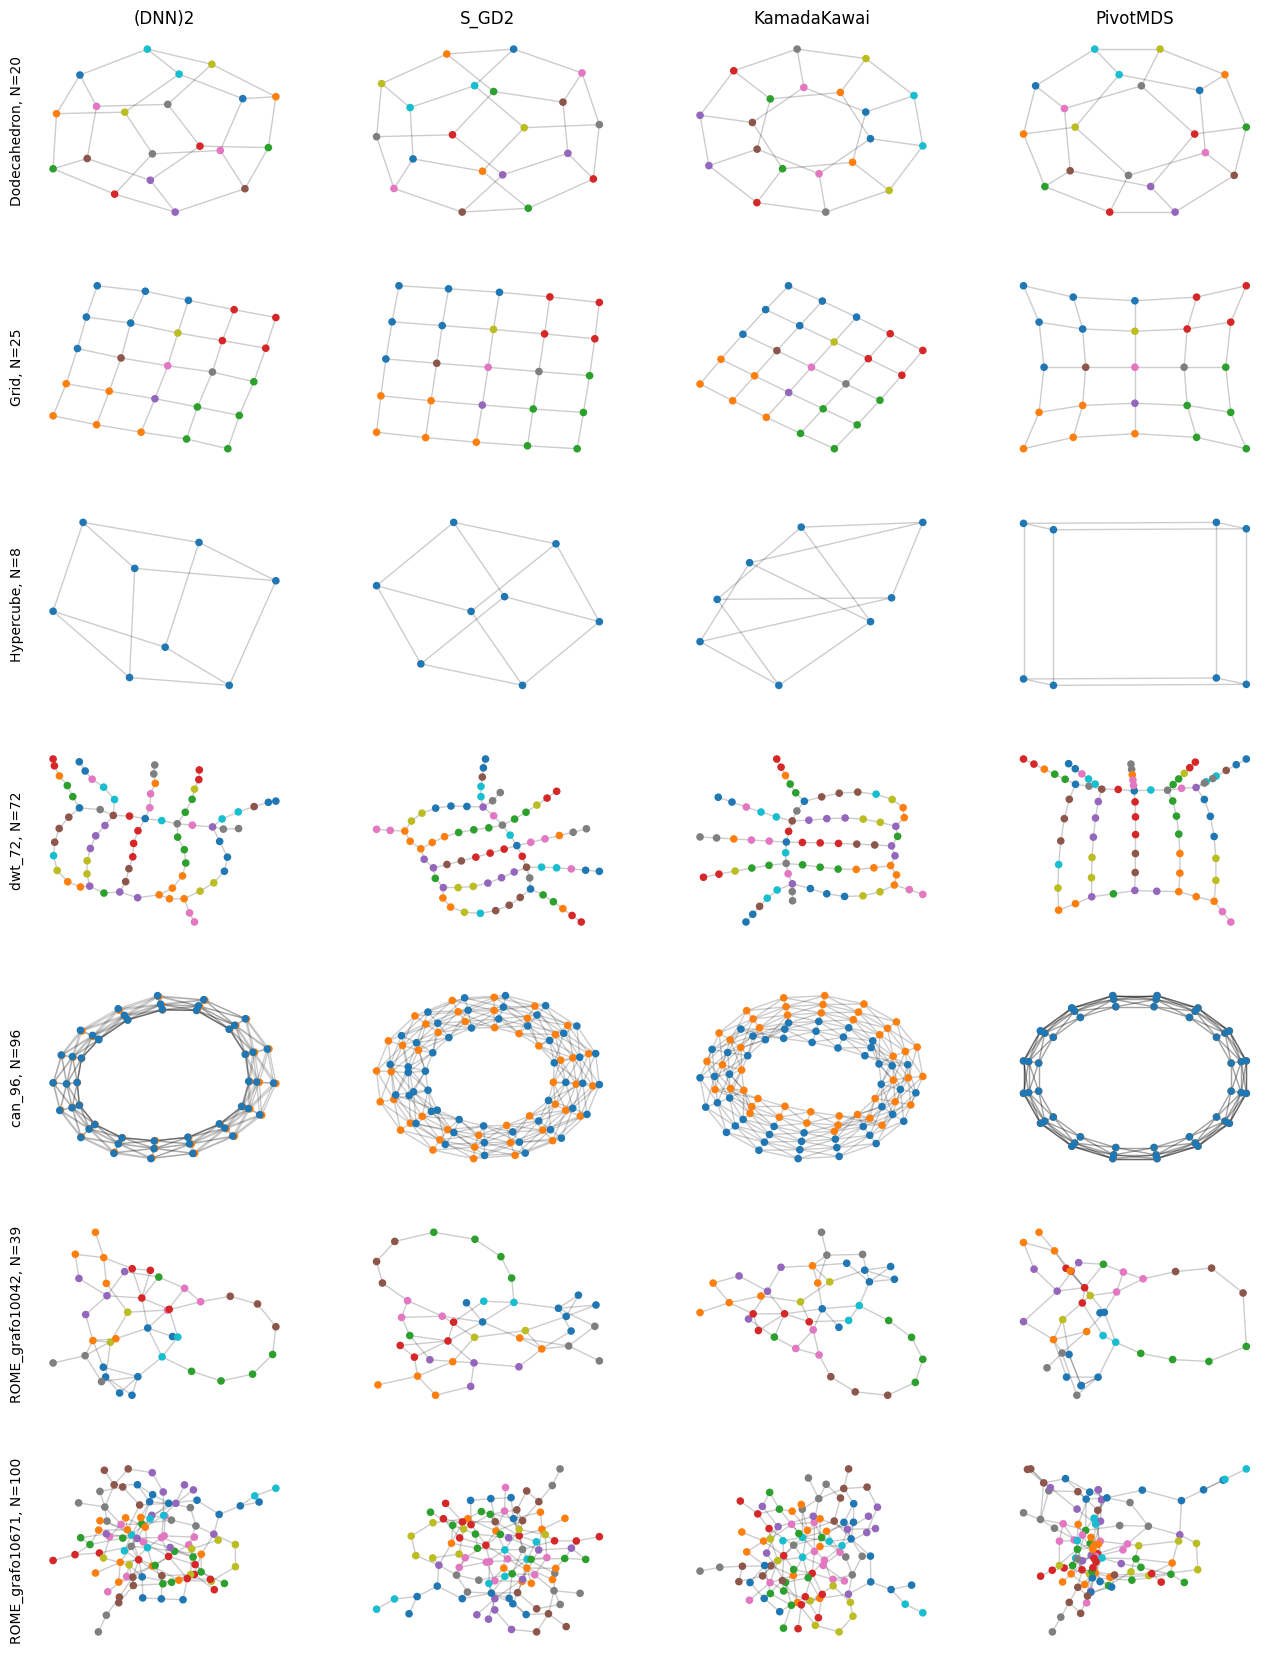

In [4]:
graphs_to_draw = [
    cust.dodecahedron(),
    cust.grid(),
    cust.hypercube(),
    cust.dwt_72(),
    cust.can_96(),
    cust.ROME_file("./data/rome_graphs/test/grafo10042.39.tlpb.gz"),
    cust.ROME_file("./data/rome_graphs/test/grafo10671.100.tlpb.gz"),
]

other_drawers = [SOTA.S_GD2(), SOTA.KamadaKawai(), SOTA.PivotMDS()]

one_graph_drawing_width = 4
one_graph_drawing_height = 3
plt.rcParams["figure.figsize"] = (one_graph_drawing_width * (1+len(other_drawers)), one_graph_drawing_height * len(graphs_to_draw))
fig, axes = plt.subplots(nrows = len(graphs_to_draw), ncols=len(other_drawers)+1)

monitor = {}

for g_idx, (g, gname) in enumerate(graphs_to_draw):
    N = g.numberOfNodes()
    AM = gp.graph2AM(g)
    DM = gp.AM2DM(AM)
    mask = np.ones((N, 1))   
    dnn2_pos = dnn2.layout(g)
    title = DNN2_title if g_idx == 0 else ""
    plotNL(dnn2_pos, AM, mask, title=title, ylabel=gname+", N="+str(N), ax=axes[g_idx][0])
    monitor[gname] = {"DM":DM, dnn2.name:dnn2_pos}    

    for i_od, od in enumerate(other_drawers):
        od_pos = od.layout(DM, mask)
        monitor[gname][od.name] = od_pos
        title = od.name if g_idx == 0 else ""
        plotNL(od_pos, AM, mask, title=title, ax=axes[g_idx][1+i_od])
plt.show()

# Metrics computation

all metrics are  ['stress', 'stress_normalized', 'aspect_ratio', 'edges_crossing_number', 'angular_resolution', 'angular_resolution_normalized', 'autocorr_cluster_ambiguity', 'edges_length_uniformity', 'neighborhood_preservation_gd2', 'neighborhood_preservation_tsnet', 'nodes_overlap', 'nodes_resolution']


/home/lgiovannange/_code/DNN2/code/metrics.py:148: RuntimeWarning: invalid value encountered in double_scalars
  return math.degrees(np.arccos((p1c**2+p0c**2-p0p1**2)/(2*p1c*p0c)))


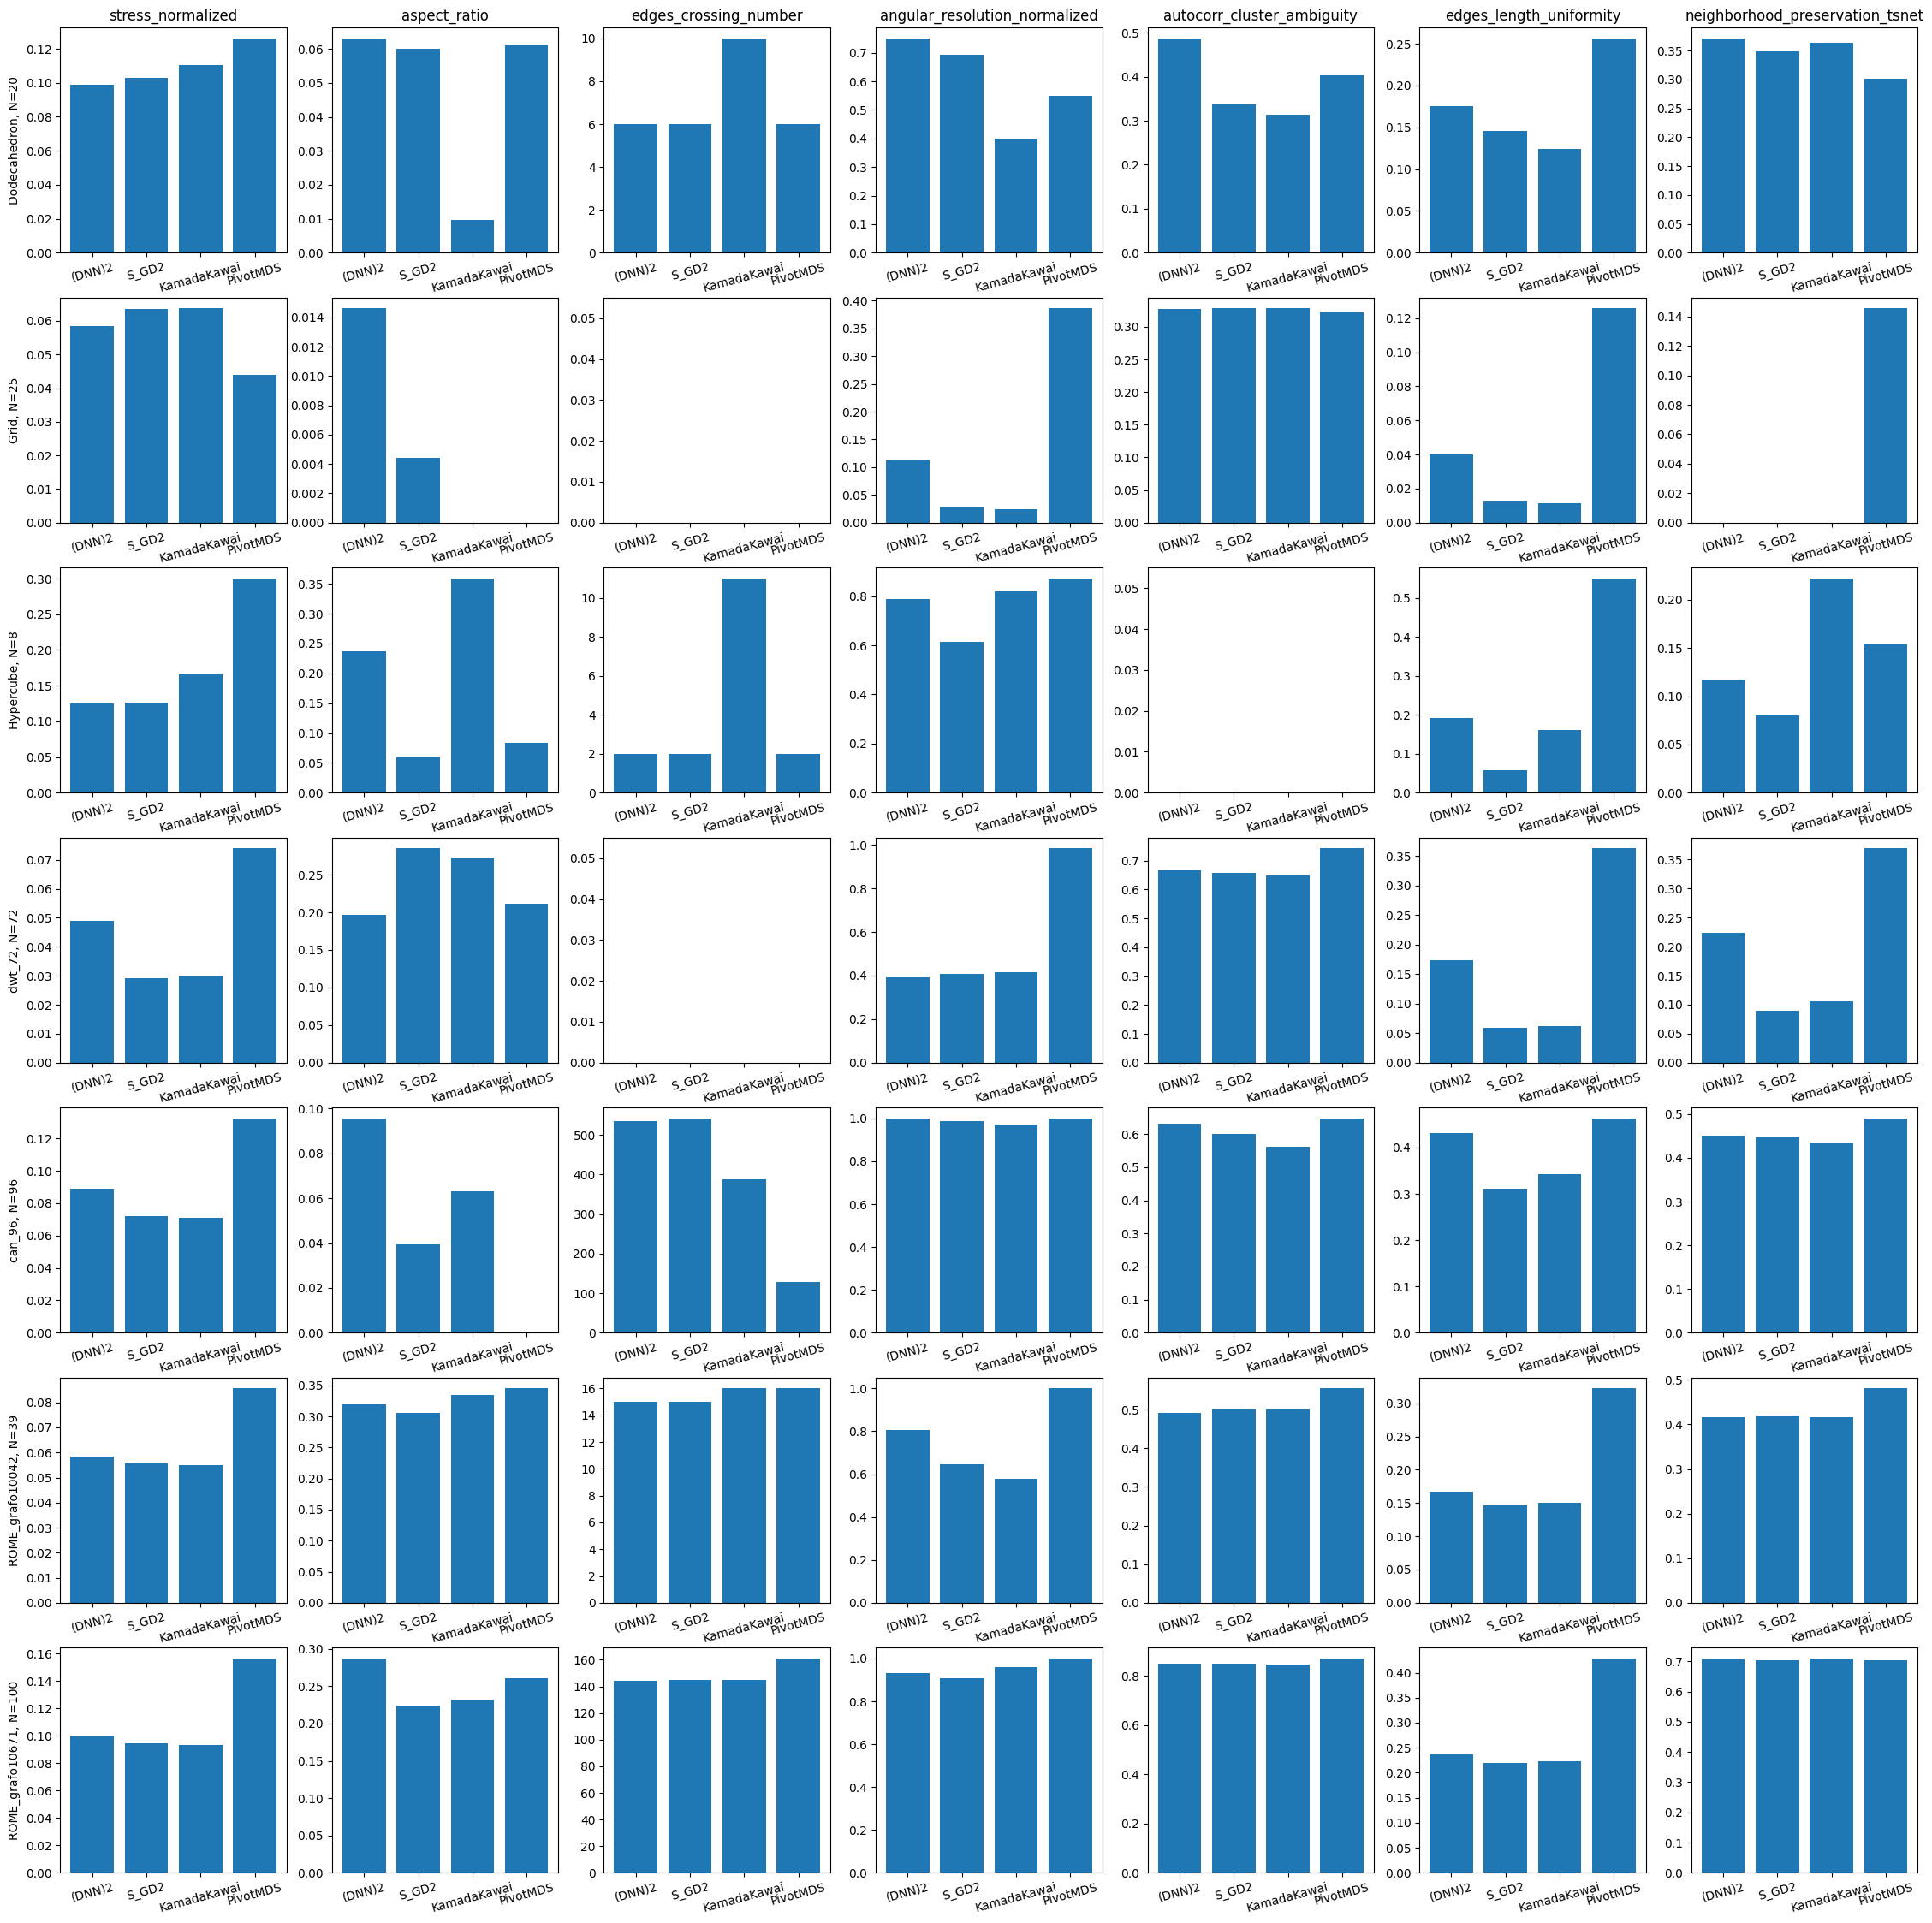

In [5]:
# metrics must be a selection of metrics.metrics
print("all metrics are ", metrics.metrics)
wanted_metrics = ["stress_normalized", "aspect_ratio", "edges_crossing_number", "angular_resolution_normalized", "autocorr_cluster_ambiguity", "edges_length_uniformity", "neighborhood_preservation_tsnet"]

one_cell_width = 4
one_cell_height = 4
plt.rcParams["figure.figsize"] = (one_cell_width * (len(wanted_metrics)), one_cell_height * len(graphs_to_draw))
fig, axes = plt.subplots(nrows = len(graphs_to_draw), ncols=len(wanted_metrics))

X = [DNN2_title, *[d.name for d in other_drawers]]
graphs = monitor.keys()
for i_m, metric in enumerate(wanted_metrics):
    metric_fn = getattr(metrics, metric)
    for i_g, g in enumerate(graphs):
        DM = monitor[g]["DM"]
        N = DM.shape[0]
        mask = np.ones((N,1))
        
        Y = [metric_fn(monitor[g][dnn2.name], DM, mask)]
        for od in other_drawers:
            Y.append(metric_fn(monitor[g][od.name], DM, mask))
        axes[i_g][i_m].bar(X, Y)
        axes[i_g][i_m].set_xticks(X)
        axes[i_g][i_m].set_xticklabels(X, rotation = 15)
        if(i_m == 0):
            axes[i_g][i_m].set_ylabel(g+", N="+str(N))
        if(i_g == 0):
            axes[i_g][i_m].set_title(metric)
        axes[i_g][i_m].set_ylim(bottom=0)
plt.show()